<a href="https://colab.research.google.com/github/EdoardoMorucci/Plant-Leaves-Search-Engine---MIRCV/blob/main/vpt_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vantage Point Tree Index

Useful import

In [1]:
from statistics import median
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy import dot
from numpy.linalg import norm
import random
import math
import pandas as pd
import pickle
import os


The **Object** is the data structure that contains the informations related to one image:
* **Features**  is the numpy vector (controlla che lo sia e se lo è mettilo anche giù nel commento della classe) extracted using the CNN model
* **Id** is the identifier used to retrieve the image from the dataframe

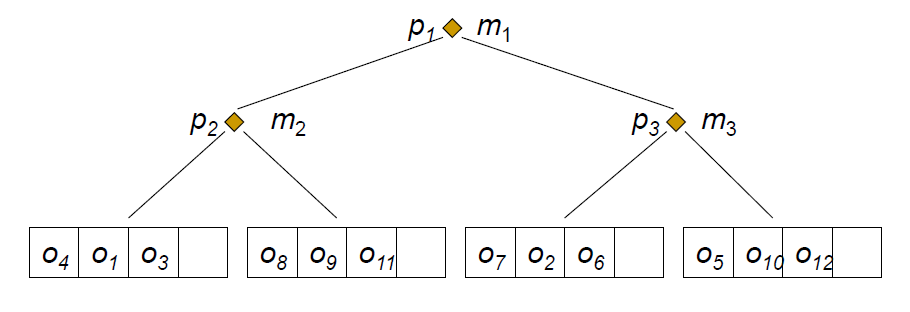


It is like the Object **O<sub>1</sub>** or **O<sub>2</sub>** or also the Pivot **p<sub>1</sub>** present in this example of VPT.

In [2]:
class Object:
  ''' Class containing information about an Image
      Attributes:
        - features (dtype): vector of features of 1024
        - id (string): id of the image
  '''
  def __init__(self, features, id):
    self.features = features
    self.id = id

  def __str__(self):
    return (f"Object-> Path:{self.id} Features:{self.features}")



The **Node** is the data structure that will act as the building block for the tree, we differentiate as *intern node* and *leaf node*:
* **Intern Node** has a list of Objects, the number is parameterizable (in figure above we have 4)
* **Leaf Node** has the Pivot (that is an Object) and the Median that is the distance that allow to split the received Objects in 2 set of equal number of objects

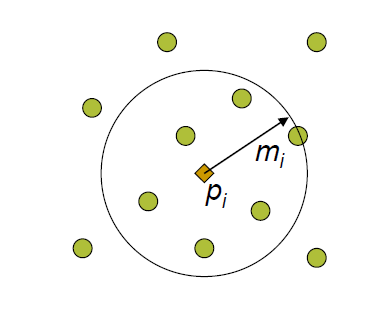

In [3]:
class Node:
  ''' Generic Node in Vantage Point Tree Index.
      Attributes:
        - pivot (Object)
        - is_leaf (Bool)
        - right (Node): right child of the node
        - left (Node): left child of the node
        - median (Float): distance that divides objects in 2 set with equal cardinality
        - Objects (List of Objects): objects that must be stored in leaf node
      Methods:
        - to_dict: serialize Tree in Pickle
        - from_dict: recreates the Tree from Pickle
  '''
  
  def __init__(self, is_leaf=False, **kwargs):
    self.right = kwargs.get("right", None)
    self.left = kwargs.get("left", None)
    self.is_leaf = is_leaf
    if is_leaf:
      self.objects = kwargs.get("objects", [])
    else:
      self.pivot = kwargs.get("pivot", None)
      self.median = kwargs.get("median", None)


  def __str__(self, level=0, side="ROOT"):
    if self.is_leaf:
      ret = ""
      for obj in self.objects:
        ret += "\t"*level+ side + " " + str(obj)+"\n"
      return ret
    else:
      ret = "\t"*level+ "Pivot " + side + " " +str(self.pivot) +"\n"
      ret += self.left.__str__(level+1, "left")
      ret += self.right.__str__(level+1, "right")
      return ret


  def to_dict(self):
    if self.is_leaf:
      objects = self.objects
    else:
      pivot = self.pivot
      median = self.median

    left = self.left
    if left is not None:
      left = left.to_dict()
    right = self.right
    if right is not None:
      right = right.to_dict()
    if self.is_leaf:
      return {'objects':objects, 'left':left, 'right':right}
    else:
      return {'pivot':pivot, 'median': median, 'left':left, 'right':right}

  @classmethod
  def from_dict(cls, D):
   left = D['left']
   right = D['right']

   if left is None and right is None:
     objects = D['objects']
   else:
     pivot = D['pivot']
     median = D['median']
   
   if left is not None:
     left = cls.from_dict(left)

   if right is not None:
     right = cls.from_dict(right)

   if left is None and right is None:
     tmp_node = cls(is_leaf=True, objects=objects, left=left, right=right)
   else:
     tmp_node = cls(is_leaf=False, pivot=pivot, median=median, left=left, right=right)

   return tmp_node


In [24]:
class VantagePointTree:
  ''' Class containing index VPT
  '''

  def __init__(self, features=None, size=None, from_disk=False, root=None, distance_measure="cosine_similarity"):
    self.root = Node()
    self.distance_measure = distance_measure
    self.size = size
    if from_disk:
      self.root = root
    else:
      self.insert(self.root, self.append_id(features))

  def __str__(self):
    return str(self.root)

  def append_id(self, features):
    features_and_ids = []
    for i in range(len(features)):
      features_and_ids.append(Object(features[i],str(i)))
    return features_and_ids
        

  def insert(self,node,set):
      """ Recursive function that creates the VPT Index from a set of Objects.
      Args:
        - set (List of Object): the set of Object(s) from which create the VPT.
      Returns:
        - Doesn't return anything because It sets the Tree Data Structure in the
          proper way.
      """
      
      if node.is_leaf:
        node.objects = set
        return
      else:
        node.objects = None

      # randomly select Pivot
      node.pivot = random.choice(set)

      # partition the set and find the median
      set1, set2, median = self.partition_set_by_median(node.pivot,set)

      # assign the medin to the current node
      node.median = median

      # set if the next Node will be Leaf or Internal Node according to the number
      # of Object remaining in the set1 and set2
      if len(set1) <= 4:
        node.left = Node(is_leaf=True)
      else:
        node.left = Node(is_leaf=False)

      if len(set2) <= 4:
        node.right = Node(is_leaf=True)
      else:
        node.right = Node(is_leaf=False)

      self.insert(node.left, set1)
      self.insert(node.right, set2)
  
  def partition_set_by_median(self, pivot, set):
    """ Partition in two set using the median.
    Args:
      - pivot (Object): the choosen Pivot.
      - set (List of Object): the set of Object(s) to be partitioned.
    Returns:
      - set1 (List of Object): the Object(s) that are inside the ball with center
                              the Pivot and radius the median.
      - set1 (List of Object): the Object(s) that are outside the ball with center
                              the Pivot and radius the median.
      - median (Float): the median distance between Pivot and all the set of 
                        Object(s) that allows to split in 2 similar part the set.
    """

    set1 = []
    set2 = []
    median = None

    distances = []

    # compute the distances between Pivot and all Object(s)
    for x in set:
      dist = self.compute_distance(pivot.features, x.features)
      distances.append(dist)

    # compute the median
    median = np.percentile(distances, 50)
    tmp = list(zip(set,distances))

    # use the distance to sort the Object(s)
    tmp.sort(key=lambda x: x[1])

    # put in the right set all the Object(s) according to their distance wrt Pivot
    for x in tmp:
      if x[1] == 0:
        continue
      if x[1] <= median:
        set1.append(x[0])
      else:
        set2.append(x[0])

    return set1, set2, median


  def search_kNN(self, query, k):
    # initialization of the vector containing the distances and the Objects
    kNN = np.zeros(k)
    dNN = np.zeros(k)
    for i in range(k):
      kNN[i] = None
      dNN[i] = math.inf

    distance_computations = 0
    kNN, dNN, distance_computations = self.search_tree(self.root, kNN, dNN, query, distance_computations, k)

    return kNN, dNN, distance_computations

  def search_leaf(self, node, kNN, dNN, query, distance_computations,k):
    for obj in node.objects:
      distance_query_obj = self.compute_distance(query.features, obj.features)
      distance_computations = distance_computations + 1
      if distance_query_obj < dNN[k-1]:
        kNN, dNN = self.reorder_array(distance_query_obj, dNN, obj, kNN, k)
        
    return kNN, dNN, distance_computations

  def search_tree(self, node, kNN, dNN, query, distance_computations, k):
    """ Search in the VPT k Objects closest to the Query.
    Args:
      - Query (Object)
      - k (Int)
      - node (Node)
      [...]
    Returns:
      - kNN (List of Object): current best k Nearest Neighbour wrt Query Object.
      - dNN (List of Float): current best k Distances from Query to NNs.
      - distance_computations (Int): Number of Distance Computations done so far.
    """
    if not node.is_leaf:
      distance_query_pivot = self.compute_distance(query.features, node.pivot.features)
      distance_computations = distance_computations + 1

      # if the distance is less than the greater distance found so far
      if distance_query_pivot < dNN[k-1]:
        kNN, dNN = self.reorder_array(distance_query_pivot, dNN, node.pivot, kNN, k)
          
      if distance_query_pivot - dNN[k-1] <= node.median:
        kNN, dNN, distance_computations = self.search_tree(node.left, kNN, dNN, query,distance_computations,k)

      if distance_query_pivot + dNN[k-1] >= node.median:
        kNN, dNN, distance_computations = self.search_tree(node.right, kNN, dNN, query, distance_computations,k)
      
    else:
      kNN, dNN, distance_computations = self.search_leaf(node, kNN, dNN, query, distance_computations,k)

    return kNN, dNN, distance_computations


  def reorder_array(self, distance, dNN, node, kNN, k):
    """ Reorder the kNN, dNN using the new found Object.
    Args:
      - Distance (Int): Distance to be added in the dNN
      - node (Node): Node to be added in the kNN
      [...]
    Returns:
      - kNN (List of Object): ordered using also the added Object.
      - dNN (List of Float): ordered using also the added Distance.
    """
    # pair Distances with the respective Objects
    tmp = list(zip(dNN,kNN))
    tmp.append((distance,node))
    # sort using as key the distances
    tmp.sort(key=lambda x: x[0])
    # cut off the farthest object from query
    tmp = tmp[0:k]
    res = list(zip(*tmp))
    dNN = res[0]
    kNN = res[1]
    return kNN, dNN

  def compute_distance(self, features1, features2):
    if self.distance_measure == "manhattan":
      return sum(abs(a-b) for a, b in zip(features1,features2))
    else:
      # Euclidean distance
      return np.sqrt(np.sum(np.square(features1-features2)))

  def save_on_disk(self, tree_file_name):
    dict_tree = Node.to_dict(self.root)
    with open(tree_file_name, 'wb') as f:
      pickle.dump(dict_tree, f)
    return
  

In [30]:
'''
FEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features_new.npy"
features = np.load(FEATURES_PATH)


vp_tree_index = VantagePointTree(features, distance_measure="euclidian", size=len(features))
vp_tree_index.save_on_disk("saved_tree.pkl")


with open('saved_tree.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

new_root = Node.from_dict(loaded_dict)
new_tree = VantagePointTree(root=new_root, size=len(features), from_disk=True, distance_measure="cosine_similarity")
'''

'\nFEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features_new.npy"\nfeatures = np.load(FEATURES_PATH)\n\n\nvp_tree_index = VantagePointTree(features, distance_measure="euclidian", size=len(features))\nvp_tree_index.save_on_disk("saved_tree.pkl")\n\n\nwith open(\'saved_tree.pkl\', \'rb\') as f:\n    loaded_dict = pickle.load(f)\n\nnew_root = Node.from_dict(loaded_dict)\nnew_tree = VantagePointTree(root=new_root, size=len(features), from_disk=True, distance_measure="cosine_similarity")\n'

In [16]:
'''
dict_tree = Node.to_dict(vp_tree_index.root)

with open('saved_tree.pkl', 'wb') as f:
    pickle.dump(dict_tree, f)

with open('saved_tree.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

new_root = Node.from_dict(loaded_dict)
new_tree = VantagePointTree(root=new_root, size=len(features), from_disk=True, distance_measure="cosine_similarity")
'''

VPT Index creation...


In [29]:
'''
import time
query = Object(features[72000], "Query")

start = time.time()

kNN, dNN, distance_computations = new_tree.search_kNN(query,10)

tempo_messo = time.time() - start

print(f"Tempo impiegato {tempo_messo}")

k=10

for i in range(k):
  print(kNN[i].id)
  print(dNN[i])

print(f"Ho computato {distance_computations} su {vp_tree_index.size} oggetti nell'indice")
'''

Tempo impiegato 0.7528858184814453
72000
0.0
52093
21.018135
55972
21.899681
67993
22.037794
57899
22.829988
63416
22.829988
48776
22.915493
53786
22.915493
71125
23.012262
52383
23.351599
Ho computato 33704 su 97034 oggetti nell'indice


Example of fake features

In [ ]:
'''
features_and_paths = []
for i in range(1,11):
  a = np.array([i**2,i**2])
  features_and_paths.append(Object(a,"Ciao"+str(i)))

vpt_index = VantagePointTree(features_and_paths, len(features_and_paths), from_disk=False, distance_measure="manhattan")
print(vpt_index)
'''

In [ ]:
'''
query = Object([3600,3600], "Query")
k=3
kNN, dNN, distance_computations = vpt_index.search_kNN(query,k)
for i in range(k):
  print(kNN[i].id)
  print(dNN[i])
print(distance_computations)
print(vpt_index.size)
'''

Ciao60
0
Ciao59
238
Ciao61
242
138
499


##PARAMETRI PER PERFORMANCE EVALUATION
cose parametrizzabili del VPT:
* come viene calcolata la **distanza** (cosine similarity non funge)
* **scelta del pivot** (non implementata)
* **numero oggetti nella leaf**, non so se ha senso o se è carina ma da provare